In [1]:
import numpy as np
from numpy import array, arange
from numpy import exp, sqrt, pi as π
from numpy import ceil, log2
from numpy import prod
from numpy import histogram
from scipy.fft import dct, idct
from scipy.optimize import brentq


########################################
# Main                                 #
########################################

def kde1d(x, n=1024, limits=None):
    """
    Estimates the 1d density from discrete observations.

    The input is a list/array `x` of numbers that represent discrete
    observations of a random variable. They are binned on a grid of
    `n` points within the data `limits`, if specified, or within
    the limits given by the values' range. `n` will be coerced to the
    next highest power of two if it isn't one to begin with.

    The limits may be given as a tuple (`xmin`, `xmax`) or a single
    number denoting the upper bound of a range centered at zero.
    If any of those values are `None`, they will be inferred from the
    data.

    After binning, the function determines the optimal bandwidth
    according to the diffusion-based method. It then smooths the
    binned data over the grid using a Gaussian kernel with a standard
    deviation corresponding to that bandwidth.

    Returns the estimated `density` and the `grid` upon which it was
    computed, as well as the optimal `bandwidth` value the algorithm
    determined. Raises `ValueError` if the algorithm did not converge.
    """

    # Convert to array in case a list is passed in.
    x = array(x)

    # Round up number of bins to next power of two.
    n = int(2**ceil(log2(n)))

    # Determine missing data limits.
    if limits is None:
        xmin = xmax = None
    elif isinstance(limits, tuple):
        (xmin, xmax) = limits
    else:
        xmin = -limits
        xmax = +limits
    if None in (xmin, xmax):
        delta = x.max() - x.min()
        if xmin is None:
            xmin = x.min() - delta/10
        if xmax is None:
            xmax = x.max() + delta/10

    # Determine data range, required for scaling.
    Δx = xmax - xmin

    # Determine number of data points.
    N = len(x)

    # Bin samples on regular grid.
    (binned, edges) = histogram(x, bins=n, range=(xmin, xmax))
    grid = edges[:-1]

    # Compute 2d discrete cosine transform, then adjust first component.
    transformed = dct(binned/N)
    transformed[0] /= 2

    # Pre-compute squared indices and transform components before solver loop.
    k  = arange(n, dtype='float')      # "float" avoids integer overflow.
    k2 = k**2
    a2 = (transformed/2)**2

    # Define internal function to be solved iteratively.
    def ξγ(t, l=7):
        """Returns ξ γ^[l] as a function of diffusion time t."""
        f = 2*π**(2*l) * sum(k2**l * a2 * exp(-π**2 * k2*t))
        for s in range(l-1, 1, -1):
            K = prod(range(1, 2*s, 2)) / sqrt(2*π)
            C = (1 + (1/2)**(s+1/2)) / 3
            t = (2*C*K/N/f)**(2/(3+2*s))
            f = 2*π**(2*s) * sum(k2**s * a2 * exp(-π**2 * k2*t))
        return (2*N*sqrt(π)*f)**(-2/5)

    # Solve for optimal diffusion time t*.
    try:
        ts = brentq(lambda t: t - ξγ(t), 0, 0.1)
    except ValueError:
        raise ValueError('Bandwidth optimization did not converge.') from None

    # Apply Gaussian filter with optimized kernel.
    smoothed = transformed * exp(-π**2 * ts/2 * k**2)

    # Reverse transformation after adjusting first component.
    smoothed[0] *= 2
    inverse = idct(smoothed)

    # Normalize density.
    density = inverse * n/Δx

    # Determine bandwidth from diffusion time.
    bandwidth = sqrt(ts) * Δx

    # Return results.
    return (density, grid, bandwidth)

(array([ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         1.,  2.,  2.,  3.,  4.,  6.,  7.,  7.,  6.,  5., 12.,  6.,  6.,
         6., 13.,  9.,  8.,  8., 11., 15., 17., 26., 20., 13., 21., 31.,
        17., 30., 28., 46., 37., 34., 47., 31., 41., 38., 40., 32., 45.,
        57., 52., 57., 46., 46., 66., 58., 65., 52., 53., 49., 56., 61.,
        41., 45., 53., 60., 45., 39., 55., 44., 48., 50., 47., 40., 40.,
        38., 28., 35., 25., 28., 21., 29., 27., 20., 24., 23., 18., 20.,
        26., 19., 20., 21., 13., 10., 13., 14., 11., 23., 14., 17., 14.,
        13., 16., 24., 25., 18., 22., 27., 28., 33., 24., 41., 37., 30.,
        36., 31., 37., 34., 44., 47., 28., 44., 43., 46., 42., 49., 49.,
        43., 49., 62., 53., 62., 51., 49., 40., 66., 54., 50., 51., 52.,
        59., 45., 39., 49., 39., 40., 26., 33., 33., 34., 41., 33., 31.,
        26., 33., 23., 27., 32., 10., 17., 12., 20., 14.,  9., 13., 14.,
         8.,  8., 11.,  4., 11.,  5.,  8.,  1.,  5.

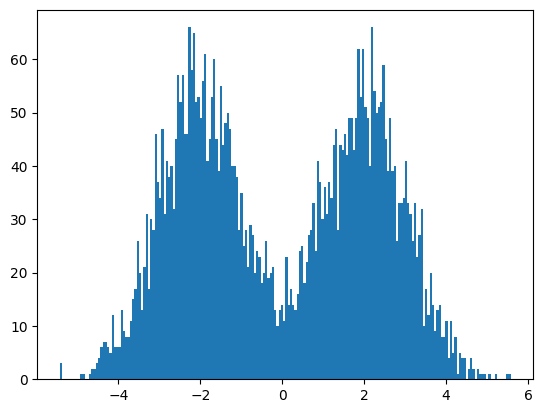

In [2]:
import matplotlib.pyplot as plt

X = np.random.normal(loc=0, scale=1, size=5000) + 2*(2*np.random.binomial(n=1, p=0.5, size=5000)-1)
plt.hist(X, bins = 200)

In [3]:
density, grid, bandwidth = kde1d(X)

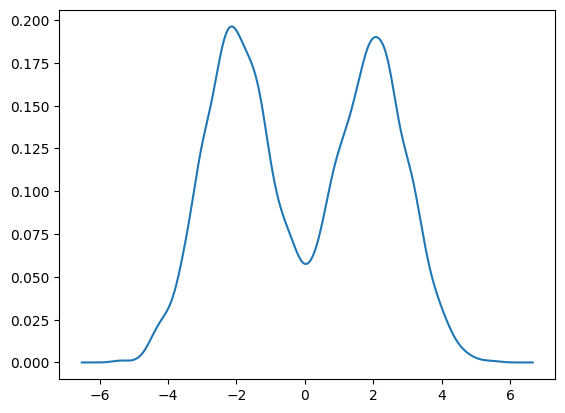

In [4]:
plt.plot(grid, density)